# HSE Summer School NLP&DA

![](https://www.hse.ru/data/2014/06/25/1309038576/logo_hse_cmyk_e.jpg)

Учебный проект по теме "Тональность отношений субъектов (именованных сущностей)", предполагающий разработку участниками школы под руководством тьюторов программных средств, решающих задачу определения мнения сторон о различных событиях, освещаемых в новостях

Нужен алгоритм, который по выделенным сущностям может найти пары этих сущностей в тексте и вырезать соответствующие куски между ними + несколько слов справа-слева. Возможно, имеет смысл идти от N-ой выделенной сущности до N+2, и включать всё до неё. 

Чем может помочь синтаксический анализ?

Чем поможет морфологический анализ?

In [2]:
import sys 
sys.path.append("/Users/dmitrys/anaconda2/lib/python2.7/site-packages/")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymorphy2
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

import pymorphy2
morph = pymorphy2.MorphAnalyzer()


from pymystem3 import Mystem

m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

import string
%matplotlib inline

In [3]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [56]:
def commit():
    ! git add NLP_summerschool.ipynb
    ! git commit -m "and now for something comepletely different - ML"
    ! git push -u origin master

In [57]:
commit()

[master 5be9670] and now for something comepletely different - ML
 1 file changed, 220 insertions(+), 507 deletions(-)
Counting objects: 3, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 2.13 KiB | 0 bytes/s, done.
Total 3 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/DmitrySerg/HSE-NLP-Summer-School.git
   2aa104c..5be9670  master -> master
Branch master set up to track remote branch master from origin.


## Utility functions

In [58]:
def loadAnswer(number):
    with open("Texts/art{}.opin.txt".format(number)) as f:
        d = f.read()
    return d

def loadText(number):
    with open("Texts/art{}.txt".format(number)) as f:
        d = f.read()
    return d

def transformAnnotation(number):
    """
    Given number loads txt file with annotation 
    Returns DataFrame with transformed annotation
    """
    with open("Texts/art{}.ann".format(number)) as f:
        d = f.read()

    d = d.split("\n")

    for i in range(len(d)):
        d[i] = d[i].split("\t")

    d = pd.DataFrame(d)
    d.drop([0], axis=1, inplace=True)
    d = pd.concat([d, pd.DataFrame(d[1].apply(lambda x: x.split()).tolist())], axis=1)
    d.columns = ["to_delete", "entity", "entity_car", "pos_1", "pos_2"]
    d.drop(["to_delete"], axis=1, inplace=True)
    d["entity"] = d["entity"].apply(lambda x: x.strip("\r"))
    d["entity"] = d["entity"].apply(lambda x: x.decode("utf8"))
    
    d = d[~d.entity.isin(["Unknown", "Author"])].entity.reset_index(drop=True)
    
    return d

def transformAnswer(number):
    """
    Given number loads txt file with answer 
    Returns DataFrame with transformed answer
    """
    answ = loadAnswer(number)
    answ = answ.split("\n")

    for i in range(len(answ)):
        answ[i] = answ[i].split(",")

    answ = pd.DataFrame(answ)
    answ.columns = ["entity_1", "entity_2", "attitude", "time"]
    answ.dropna(inplace=True)
    answ.time = answ.time.apply(lambda x: x.strip("\r"))
    
    return answ

def loadRuSentiLex():
    """
    Loads the RuSentiLex 2017 dictionary
    Returns data frame with ["word", "tag", "word_lemmatized", "tone", "certainty"]
    """
    with open("RuSentiLex2017_revised_2.txt") as f:
        Rusentilex = f.read().decode("cp1251").encode("utf8")
        Rusentilex = Rusentilex[1510:]

    Rusentilex = Rusentilex.split("\n")
    for i, item in enumerate(Rusentilex):
        Rusentilex[i] = item.split(",")

    for i in Rusentilex:
        if len(i) < 5:
            Rusentilex.remove(i)

    Rusentilex = pd.DataFrame(Rusentilex)
    Rusentilex.drop([5, 6, 7], axis=1, inplace=True)
    Rusentilex.columns = ["word", "tag", "word_lemmatized", "tone", "certainty"]
    Rusentilex["certainty"] = Rusentilex["certainty"].apply(lambda x: x.strip('\r'))
    
    
    Rusentilex["tone"] = Rusentilex["tone"].apply(lambda x: x.strip(' '))
    Rusentilex["certainty"] = Rusentilex["certainty"].apply(lambda x: x.strip(' '))
    
    return Rusentilex

def cleanString(myString):
    return myString.translate(None, string.punctuation).decode('utf-8')

def getSentimentCertainity(word):
    word = lemmatize(word)
    try:
        tone, certainty =  Rusentilex[["tone", "certainty"]][Rusentilex.word.isin([word])].values[0]
    except:
        try:
            tone, certainty =  Rusentilex[["tone", "certainty"]][Rusentilex.word.isin([word.encode("utf8")])].values[0]
        except:
            tone, certainty = "NaN", "NaN"
    return tone, certainty

![](http://cathyreisenwitz.com/wp-content/uploads/2016/01/no.jpg)

Словарь РуСентиЛекс

Структура: 
- 1 слово или словосочетание,
- 2 Часть речи или синтаксический тип группы,
- 3 слово или словосочетание в лемматизированной форме, 
- 4 Тональность: позитивная (positive), негативная(negative), нейтральная (neutral) или неопределеная оценка, зависит от контекста (positive/negative),
- 5 Источник: оценка (opinion), чувство (feeling), факт (fact),
- 6 Если тональность отличается для разных значений многозначного слова, то перечисляются все значения слова по тезаурусу РуТез и дается отсылка на сооветствующее понятие - имя понятия в кавычках.

In [59]:
Rusentilex = loadRuSentiLex()

In [9]:
Rusentilex.head()

,word,tag,word_lemmatized,tone,certainty
0,аборт,Noun,аборт,negative,fact
1,абортивный,Adj,абортивный,negative,fact
2,абракадабра,Noun,абракадабра,negative,opinion
3,абсурд,Noun,абсурд,negative,opinion
4,абсурдность,Noun,абсурдность,negative,opinion


In [10]:
getSentimentCertainity(u"абортами".encode("utf8"))

('negative', 'fact')

In [11]:
def Text_to_dict(number):
    t = loadText(number)
    text_dict = t.split("\n\n")
    text_dict = {i:parag for i, parag in enumerate(text_dict)}
    sentence_dict = {i:{} for i in range(len(text_dict))}

    for key, paragraph in text_dict.iteritems():
        paragraph = paragraph.split("{Author, Unknown}")
        for sent_numbet, sentence in enumerate(paragraph):

            sentence = cleanString(sentence)
            if len(sentence) != 0:
                sentence_dict[key][sent_numbet] = sentence
                #tknzr.tokenize()
    return sentence_dict

In [12]:
def getEntityPositions(text, entities):
    """
    This bad boy finds (hopefully) all entities in the text
    Collects their exact locations and returns a neat Dataframe with them
    """
    
    ENTITIES = pd.DataFrame(columns=["entity", "paragraph", "sentence", "loc_start", "loc_end"])
    
    for paragraph in text:
        for sentence in text[paragraph]:
            for entity in list(entities.unique()):
                if " " + entity + " " in " " + text[paragraph][sentence] +  " ":
                    loc_start = text[paragraph][sentence].find(entity)
                    loc_end = loc_start + len(entity)
                    
                    to_append =   {"entity":entity, 
                                   "paragraph":paragraph, 
                                   "sentence":sentence,
                                   "loc_start":loc_start,
                                   "loc_end":loc_end}
                    
                    ENTITIES = ENTITIES.append(to_append, ignore_index = True)
    ENTITIES = ENTITIES.drop_duplicates()
    ENTITIES = ENTITIES.sort_values(by=["paragraph", "sentence", "loc_start"])
    ENTITIES = ENTITIES.reset_index(drop=True)
    return ENTITIES

In [13]:
def distances(loc1, loc2):
    """
    returns distances from one entity to another
    """
    paragraph = ENTITIES.loc[loc2].paragraph - ENTITIES.loc[loc1].paragraph
    sentence = ENTITIES.loc[loc2].sentence - ENTITIES.loc[loc1].sentence
    return paragraph, sentence

In [14]:
def getMorphCase(word):
    p = morph.parse(u"аборт")[0]
    return p.tag.case

In [15]:
def getPairs(ENTITIES, text, n_entities=2):
    N_ENTITIES = n_entities # глобальный параметр, сколько сущностей будем перебирать для текущей
    PAIRS = pd.DataFrame(columns=["entity_1", "entity_2", "sentence"])
    ent_1_number = 0
    while ent_1_number < len(ENTITIES):

        entity_1 = ENTITIES.entity[ent_1_number]
        for ent_2_number in range(N_ENTITIES):
            try:            
                ent_2_number = ent_1_number+ent_2_number+1
                entity_2 = ENTITIES.entity[ent_2_number]
                par_dist, sent_dist = distances(ent_1_number, ent_2_number)
                if lemmatize(entity_1) != lemmatize(entity_2): # не равны друг другу
                    if par_dist == 0: # в одном абзаце
                        if sent_dist == 0: # в одном предложении
                            PAIRS = PAIRS.append({"entity_1":entity_1,
                                                  "entity_2":entity_2,
                                                  "sentence":text[ENTITIES.loc[ent_1_number].paragraph][ENTITIES.loc[ent_1_number].sentence]},
                                                  ignore_index=True)
                    else:
                        #ent_1_number+=1
                        PAIRS = PAIRS.append({"entity_1":"Author",
                                                  "entity_2":entity_1,
                                                  "sentence":text[ENTITIES.loc[ent_1_number].paragraph][ENTITIES.loc[ent_1_number].sentence]},
                                                  ignore_index=True)
            except:
                continue
        ent_1_number += 1
        
    return PAIRS.drop_duplicates()

In [16]:
def getSentenceSentiment(sentence):
    cur_sentence = sentence
    cur_sentence = tknzr.tokenize(cur_sentence)
    for word in cur_sentence:
        if (len(word)<3) or (word.isdigit()):
            cur_sentence.remove(word)
    sentiment = []

    for word in cur_sentence:
        sentiment.append(getSentimentCertainity(word)[0])
        
    sentiment = [x for x in sentiment if x!="NaN"]
    
    result = [sentiment.count("negative"), sentiment.count("positive")]
    return result

In [17]:
def prepareData(number, n_entities=3):
    
    """
    Функция пока не работает, потому что зафакапил области видимости
    """
    
    """Loaging stuff"""
    
    text = Text_to_dict(number)
    entities = transformAnnotation(number)
    answer = transformAnswer(number) 
    
    ENTITIES = getEntityPositions(text=text, entities=entities)

    """Calculating stuff"""
    
    PAIRS = getPairs(ENTITIES=ENTITIES, text=text, n_entities=n_entities)
    print(PAIRS.head())
    answer["pair"] = answer.entity_1.apply(lambda x: lemmatize(x).lower())+","+\
                     answer.entity_2.apply(lambda x: lemmatize(x).lower())
    PAIRS["pair"] = PAIRS.entity_1.apply(lambda x: lemmatize(x).lower())+","+\
                    PAIRS.entity_2.apply(lambda x: lemmatize(x).lower())
    PAIRS["pair"] = PAIRS["pair"].apply(lambda x: x.encode("utf8"))

    PAIRS.drop(["entity_1", "entity_2"], axis=1, inplace=True)
    PAIRS = PAIRS.groupby(["pair"]).sum().reset_index()

    answer = answer.drop(["entity_1", "entity_2", "time"], axis=1)

    """Merging stuff"""
    
    PAIRS = PAIRS.merge(answer, on='pair', how="left")
    PAIRS = PAIRS.fillna("neutral")
    
    """Getting sentiment from stuff"""
    try:
        sent = PAIRS.sentence.apply(lambda x: getSentenceSentiment(x))
        sent = pd.DataFrame(list(sent))
        sent.columns = ["negative", "positive"]
    except:
        sent = 
        
    PAIRS = pd.concat([PAIRS, sent], axis=1)
    PAIRS = PAIRS[PAIRS.negative+PAIRS.positive != 0]
    
    return PAIRS, answer

In [20]:
FINAL = pd.DataFrame()
for number in log_progress(range(50)):
    try:
        n_entities=3


        """Loaging stuff"""

        text = Text_to_dict(number)
        entities = transformAnnotation(number)
        answer = transformAnswer(number) 

        ENTITIES = getEntityPositions(text=text, entities=entities)

        """Calculating stuff"""

        PAIRS = getPairs(ENTITIES=ENTITIES, text=text, n_entities=n_entities)
        answer["pair"] = answer.entity_1.apply(lambda x: lemmatize(x).lower())+","+\
                         answer.entity_2.apply(lambda x: lemmatize(x).lower())
        PAIRS["pair"] = PAIRS.entity_1.apply(lambda x: lemmatize(x).lower())+","+\
                        PAIRS.entity_2.apply(lambda x: lemmatize(x).lower())
        PAIRS["pair"] = PAIRS["pair"].apply(lambda x: x.encode("utf8"))

        PAIRS.drop(["entity_1", "entity_2"], axis=1, inplace=True)
        PAIRS = PAIRS.groupby(["pair"]).sum().reset_index()

        answer = answer.drop(["entity_1", "entity_2", "time"], axis=1)

        """Merging stuff"""

        PAIRS = PAIRS.merge(answer, on='pair', how="left")
        PAIRS = PAIRS.fillna("neutral")
        FINAL = FINAL.append(PAIRS, ignore_index=True)
        print(FINAL.shape)
    except:
        print("no file with number {}".format(number))
        continue
    

no file with number 0
(272, 3)
(336, 3)
(401, 3)
(519, 3)
(599, 3)
(658, 3)
(671, 3)
(721, 3)
no file with number 9
(866, 3)
(920, 3)
(978, 3)
(1033, 3)
(1334, 3)
(1387, 3)
(1408, 3)
(1504, 3)
(1540, 3)
(1587, 3)
(1598, 3)
(1677, 3)
no file with number 22
(1776, 3)
(1841, 3)
(1901, 3)
no file with number 26
(2069, 3)
(2127, 3)
(2165, 3)
(2219, 3)
(2247, 3)
(2372, 3)
(2412, 3)
(2497, 3)
(2657, 3)
(2725, 3)
(2764, 3)
(2801, 3)
(2863, 3)
(2907, 3)
(3044, 3)
(3102, 3)
(3159, 3)
(3340, 3)
(3434, 3)
no file with number 46
no file with number 47
no file with number 48
no file with number 49


In [26]:
FINAL.attitude = FINAL.attitude.apply(lambda x: x.strip(" "))

In [27]:
FINAL.attitude.value_counts()/len(FINAL)

neutral    0.903320
neg        0.058532
pos        0.038148
Name: attitude, dtype: float64

In [43]:
FINAL.to_pickle("FINAL_data.pkl")

In [41]:
FINAL.pair = FINAL.pair.apply(lambda x: x.decode("utf8"))

# ML

In [103]:
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
stop = stopwords.words('russian')

In [67]:
FINAL.sentence = FINAL.sentence.apply(lambda x: lemmatize(x))

In [86]:
FINAL

,pair,sentence,attitude
0,"author,javan",однако в российский минобороны как и в мид пол...,neutral
1,"author,resalat",это мочь становиться реальность последствие ко...,neutral
2,"author,алеппо",«мы не мочь оказывать давление на администраци...,neutral
3,"author,али хаменей",в качество пример али хаменей приводить ситуац...,neutral
4,"author,асад",издание со ссылка на срочный сообщение канал «...,neutral
5,"author,балтика",при это москва неоднократно подчеркивать что о...,neutral
6,"author,белый дом",примерно в аналогичный ключ высказываться и мо...,neutral
7,"author,вашингтон",почему же и в москва и дамаск который также ве...,neutral
8,"author,великобритания",в общий сложность дополнительный сила нато на ...,neutral
9,"author,глава немецкий мид",однако полагать алеми подобный замечание глава...,neutral


In [87]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
tf_vectorizer = TfidfVectorizer(stop_words=stop, ngram_range=(1, 2))

In [93]:
X_train_vector = tf_vectorizer.fit_transform(FINAL.sentence)
X_train_vector.shape

(3434, 21521)

In [100]:
X_train_vector.toarray()[0]

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [101]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

y = le.fit_transform(FINAL.attitude)

In [104]:
Xtr, Xval, ytr, yval  = train_test_split(X_train_vector, y, test_size=0.30, random_state=42)

In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

In [111]:
skf = StratifiedKFold(n_splits=5, random_state=7, shuffle=True)

In [112]:
def cross_val_predict_proba(estimator, X_train, y_train, skf):
    
    prediction = np.zeros([y_train.shape[0], len(np.unique(y_train))])
    for train_idx, test_idx in skf.split(X_train, y_train):
        X_train_part, X_test = X_train[train_idx, :], X_train[test_idx,:]
        y_train_part, y_test = y_train[train_idx], y_train[test_idx]
        
        estimator.fit(X_train_part, y_train_part)
        
        prediction[test_idx, :] = estimator.predict_proba(X_test)
        
    return prediction

In [202]:
logit_sgd = SGDClassifier(loss='log', random_state=42, class_weight="balanced")
rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced")

In [203]:
logit_sgd_oof_pred = cross_val_predict_proba(logit_sgd, Xtr, ytr, skf)

In [174]:
rf_oof_pred = cross_val_predict_proba(rf, Xtr, ytr, skf)

In [175]:
def get_accuracy_score(predictions, y):
    return round(accuracy_score(map(np.argmax, predictions), y), 3)

In [176]:
get_accuracy_score(logit_sgd_oof_pred, ytr)

0.809

In [178]:
logit_sgd.fit(Xtr, ytr)
logit_sgd_valid_pred = logit_sgd.predict_proba(Xval)

In [179]:
def visualize_coefficients(coef, feature_names, title, plot_num, n_top_features=25):
    interesting_coefficients = np.argsort(coef)[-n_top_features:]
    
    plt.figure(figsize=(15, 15))
    plt.subplot(510+plot_num+1)
    colors = ["blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + n_top_features), 
               feature_names[interesting_coefficients], rotation=60, ha="right", fontsize=14);
    plt.title(title)

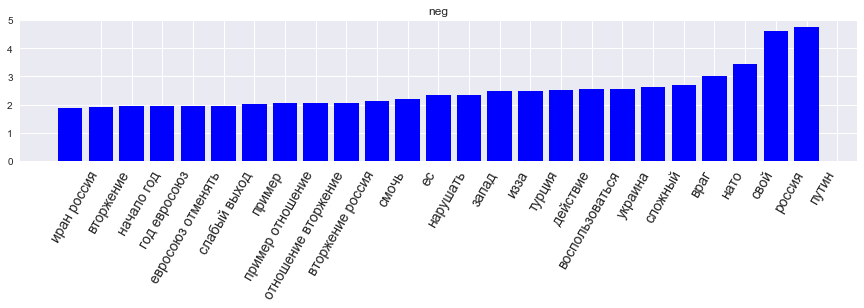

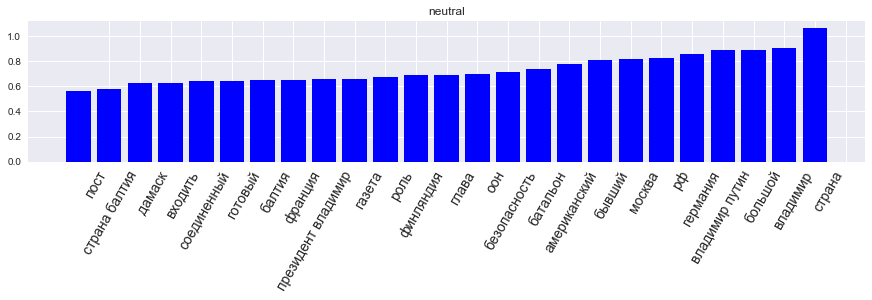

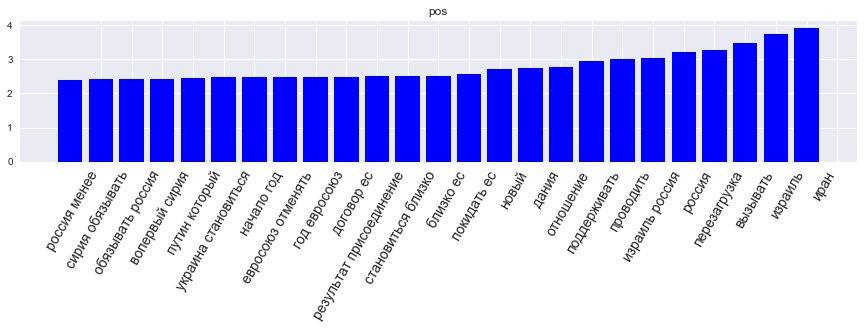

In [180]:
titles = ["neg", "neutral", 'pos']
for i in range(3):
    visualize_coefficients(logit_sgd.coef_[i,:], tf_vectorizer.get_feature_names(),
                      title=titles[i], plot_num=i)

In [183]:

rf_params_dist_grid = {
    'max_depth': np.arange(8,20, 2),
    'min_samples_leaf': np.arange(3,10,2)
}
rf_params_fixed = {
    'random_state': 7,
    'n_estimators': 300,
    "max_features":0.2,
    'n_jobs': -1
 
}

In [184]:
combinations = np.prod([len(i) for i in rf_params_dist_grid.values()])
print('Total number of combinations: {}'.format(combinations))

Total number of combinations: 24


In [187]:

rf_grid = RandomizedSearchCV(
    estimator = RandomForestClassifier(**rf_params_fixed),
    param_distributions = rf_params_dist_grid,
    cv = skf,
    scoring='f1_micro',
    n_iter = 10,
    verbose=True
)

In [188]:
%%time
rf_grid.fit(Xtr, ytr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  5.4min finished


CPU times: user 15min 58s, sys: 10.9 s, total: 16min 8s
Wall time: 5min 31s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=7, shuffle=True),
          error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.2, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False, random_state=7,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'max_depth': array([ 8, 10, 12, 14, 16, 18]), 'min_samples_leaf': array([3, 5, 7, 9])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='f1_micro', verbose=True)

In [189]:
rf_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=18, max_features=0.2, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=9,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False, random_state=7,
            verbose=0, warm_start=False)

In [190]:
from sklearn.learning_curve import validation_curve,learning_curve
def plot_with_std(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
        
def plot_learning_curve(clf, X, y, scoring, cv=5):
 
    train_sizes = np.linspace(0.05, 1, 20)
    n_train, val_train, val_test = learning_curve(clf,
                                                  X, y, train_sizes, cv=cv,
                                                  scoring=scoring, n_jobs = -1)
    plot_with_std(n_train, val_train, label='training scores', c='green')
    plot_with_std(n_train, val_test, label='validation scores', c='red')
    plt.xlabel('Training Set Size'); plt.ylabel(scoring)
    plt.legend()

In [192]:
print('Accuracy: {}'.format(round(rf_grid.best_score_, 3)))

Accuracy: 0.904


In [195]:
rfc = RandomForestClassifier(random_state=7, oob_score=True, n_estimators=200, n_jobs=-1, **rf_grid.best_params_)
rfc.fit(Xtr, ytr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=18, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=9,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=True, random_state=7,
            verbose=0, warm_start=False)

In [196]:
print('Accuracy: {}'.format(round(rfc.oob_score_, 3)))

Accuracy: 0.904


In [197]:
names = tf_vectorizer.get_feature_names()
importance = rfc.feature_importances_

feature_weights = pd.DataFrame(importance, index = names, columns = ['importance'])
feature_weights.sort_values(by=['importance'], ascending=False, inplace=True)

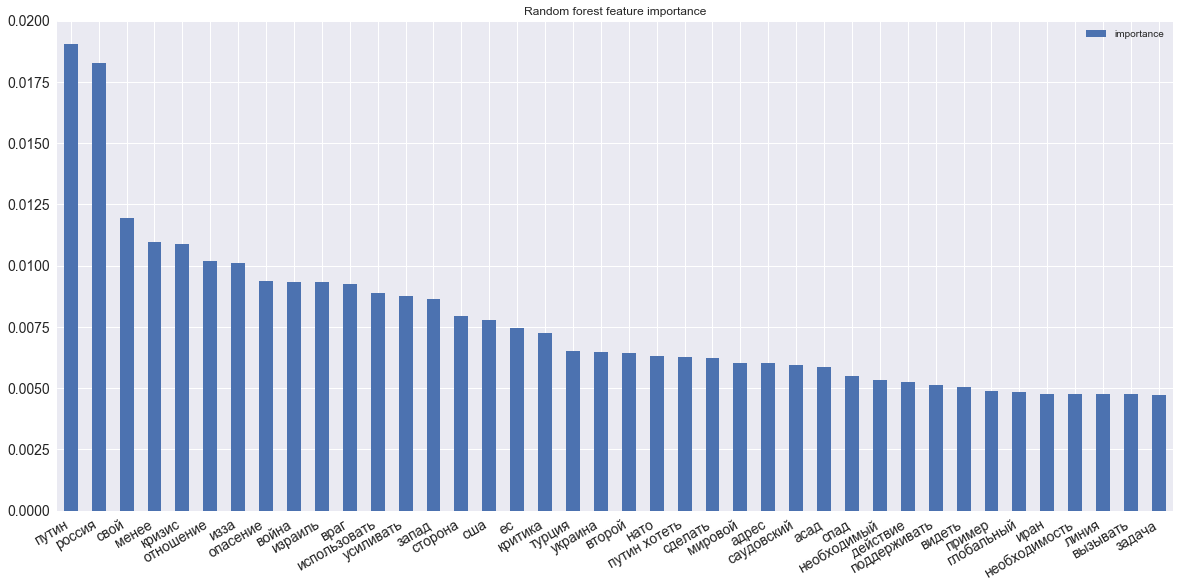

In [198]:
fig, ax = plt.subplots()
feature_weights.head(40).plot(ax=ax,kind = 'bar', figsize=(20, 10), fontsize=14)
fig.autofmt_xdate()
plt.title("Random forest feature importance");

In [199]:
def plot_confusion(predictions, title):
    array = confusion_matrix(yval, predictions)
    df_cm = pd.DataFrame(array, index = [i for i in titles],
                      columns = [i for i in titles])
    plt.figure(figsize = (7,7))
    sns.heatmap(df_cm, annot=True, fmt='g', cbar=False)
    plt.title(title);

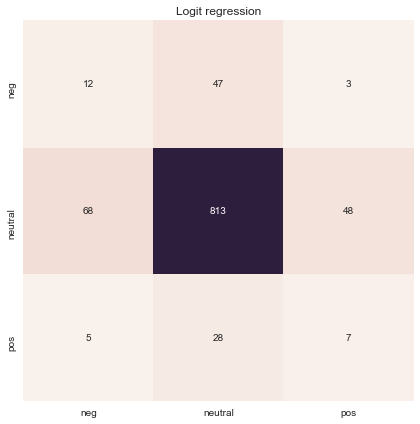

In [201]:
plot_confusion(map(np.argmax, logit_sgd.predict_proba(Xval)), "Logit regression")

In [210]:
answ = pd.DataFrame(le.inverse_transform(map(np.argmax, logit_sgd.predict_proba(Xval))))
answ.columns = ["prediction"]
answ["true"] = le.inverse_transform(yval)

In [222]:
answ = pd.DataFrame(le.inverse_transform(map(np.argmax, logit_sgd.predict_proba(X_train_vector))))
answ.columns = ["prediction"]

In [223]:
FINAL["prediction"] = answ

In [225]:
FINAL[FINAL.prediction!="neutral"]

,pair,sentence,attitude,prediction
5,"author,балтика",при это москва неоднократно подчеркивать что о...,neutral,neg
55,"али хаменей,иран",аятолла али хаменей давать оценка иранокорейск...,neutral,neg
56,"али хаменей,ири",аятолла али хаменей давать оценка иранокорейск...,neutral,neg
57,"али хаменей,республика корея",аятолла али хаменей давать оценка иранокорейск...,neutral,neg
64,"балтика,нато",при это москва неоднократно подчеркивать что о...,neutral,neg
65,"балтика,россия",при это москва неоднократно подчеркивать что о...,neutral,neg
113,"иран,resalat",аятолла али хаменей давать оценка иранокорейск...,neutral,neg
115,"иран,россия",иран и сирия входить в один группа квалификаци...,neutral,pos
116,"иран,сирия",иран и сирия входить в один группа квалификаци...,pos,pos
117,"иран,сша",аятолла али хаменей давать оценка иранокорейск...,neg,neg


In [284]:
def writeAnswer(answer, number):
    answer.to_csv("test/Answers/art{}.opin.txt".format(number), header=None, index=None, sep=' ', mode='a')

def loadText(number):
    with open("test/art{}.txt".format(number)) as f:
        d = f.read()
    return d

def transformAnnotation(number):
    """
    Given number loads txt file with annotation 
    Returns DataFrame with transformed annotation
    """
    with open("test/art{}.ann".format(number)) as f:
        d = f.read()

    d = d.split("\n")

    for i in range(len(d)):
        d[i] = d[i].split("\t")

    d = pd.DataFrame(d)
    d.drop([0], axis=1, inplace=True)
    d.dropna(inplace=True)
    d = pd.concat([d, pd.DataFrame(d[1].apply(lambda x: x.split()).tolist())], axis=1)
    d.columns = ["to_delete", "entity", "entity_car", "pos_1", "pos_2"]
    d.drop(["to_delete"], axis=1, inplace=True)
    d["entity"] = d["entity"].apply(lambda x: x.strip("\r"))
    d["entity"] = d["entity"].apply(lambda x: x.decode("utf8"))
    
    d = d[~d.entity.isin(["Unknown", "Author"])].entity.reset_index(drop=True)
    
    return d

def getPairs(ENTITIES, text, n_entities=2):
    N_ENTITIES = n_entities # глобальный параметр, сколько сущностей будем перебирать для текущей
    PAIRS = pd.DataFrame(columns=["entity_1", "entity_2", "sentence"])
    ent_1_number = 0
    while ent_1_number < len(ENTITIES):

        entity_1 = ENTITIES.entity[ent_1_number]
        for ent_2_number in range(N_ENTITIES):
            try:            
                ent_2_number = ent_1_number+ent_2_number+1
                entity_2 = ENTITIES.entity[ent_2_number]
                par_dist, sent_dist = distances(ent_1_number, ent_2_number)
                if lemmatize(entity_1) != lemmatize(entity_2): # не равны друг другу
                    if par_dist == 0: # в одном абзаце
                        if sent_dist == 0: # в одном предложении
                            PAIRS = PAIRS.append({"entity_1":entity_1,
                                                  "entity_2":entity_2,
                                                  "sentence":text[ENTITIES.loc[ent_1_number].paragraph][ENTITIES.loc[ent_1_number].sentence]},
                                                  ignore_index=True)
                    else:
                        #ent_1_number+=1
                        PAIRS = PAIRS.append({"entity_1":"Author",
                                                  "entity_2":entity_1,
                                                  "sentence":text[ENTITIES.loc[ent_1_number].paragraph][ENTITIES.loc[ent_1_number].sentence]},
                                                  ignore_index=True)
            except:
                continue
        ent_1_number += 1
        
    return PAIRS.drop_duplicates()

In [283]:
for number in range(45, 76):
    try:
        n_entities=3

        """Loaging stuff"""

        text = Text_to_dict(number)
        entities = transformAnnotation(number)
        ENTITIES = getEntityPositions(text=text, entities=entities)

        """Calculating stuff"""

        PAIRS = getPairs(ENTITIES=ENTITIES, text=text, n_entities=n_entities)

        PAIRS["pair"] = PAIRS.entity_1.apply(lambda x: lemmatize(x).lower())+","+\
                        PAIRS.entity_2.apply(lambda x: lemmatize(x).lower())
        PAIRS["pair"] = PAIRS["pair"].apply(lambda x: x.encode("utf8"))

        PAIRS.drop(["entity_1", "entity_2"], axis=1, inplace=True)
        PAIRS = PAIRS.groupby(["pair"]).sum().reset_index()

        X_test_vector = tf_vectorizer.transform(PAIRS.sentence)
        answ = pd.DataFrame(le.inverse_transform(map(np.argmax, logit_sgd.predict_proba(X_test_vector))))
        answ = pd.concat([PAIRS.pair, answ], axis=1)
        answ.columns = ["pair", "prediction"]
        answ = answ[answ.prediction!="neutral"]
        print(number, answ.shape)
        writeAnswer(answer=answ, number=number)
    except:
        print("no file number {}".format(number))

no file number 45
(46, (0, 2))
(47, (0, 2))
(48, (1, 2))
(49, (0, 2))
(50, (0, 2))
(51, (0, 2))
(52, (2, 2))
(53, (0, 2))
(54, (0, 2))
(55, (5, 2))
(56, (0, 2))
(57, (4, 2))
(58, (0, 2))
(59, (0, 2))
(60, (7, 2))
(61, (7, 2))
(62, (0, 2))
(63, (2, 2))
(64, (0, 2))
(65, (6, 2))
(66, (0, 2))
(67, (4, 2))
(68, (0, 2))
(69, (7, 2))
no file number 70
no file number 71
(72, (1, 2))
(73, (0, 2))
(74, (0, 2))
(75, (5, 2))
